# Métodos Hierárquicos

In [1]:
# numpy for mathematics
import numpy as np

# pandas for data science
import pandas as pd

# matplotlib for plotting
from matplotlib import pyplot as plt

from auxiliary_func import *


## Processamento do Ficheiro

Lê-se o ficheiro de dados tratado, constrói-se o conjunto de variáveis categóricas e contínuas. Define-se o conjunto de variáveis explicativas e resposta.

In [2]:
from sklearn.impute import KNNImputer

df = pd.read_csv("MI.csv", header=None, index_col=0)
df = df.replace("?", np.nan)
df.drop(df.loc[:, 112:114], axis=1, inplace=True)
df.drop(df.loc[:, 116:123], axis=1, inplace=True)

Cols50pc = df.isna().sum().apply(lambda x: x > 850)
lessThan50pc = list(Cols50pc[Cols50pc == True].index)

# Delete colums with 30% of missing values
df.drop(df[lessThan50pc], axis=1, inplace=True)

continuous_ind = list(set([1, 34, 35, 36, 37, 83, 85, 86,
                      87, 88, 89, 90]) - set(lessThan50pc))  # Labels contínuas (obtidas do site)

categorical_ind = list(set(df.columns) - set(continuous_ind))

df_cont = pd.DataFrame()  # Data Frame contínuo
df_cat = pd.DataFrame()  # Data Frame categórico

cols = df.columns

imputer = KNNImputer(n_neighbors=1)
df = imputer.fit_transform(df)

df = pd.DataFrame(df, columns=cols)

j = 0  # Construction of data frames
for i in continuous_ind:
    df_cont.insert(j, i, df.loc[:, i])
    j = j + 1
j = 0
for i in categorical_ind:
    df_cat.insert(j, i, df.loc[:, i])
    j = j + 1


In [3]:


X = df.drop(115, axis=1)

X_cat = df_cat.drop(labels={115}, axis=1)

X_cont = df_cont

target = df[[115]]


## Análise

Grande parte são variáveis categóricas e binárias.

Novamente há várias coisas a testar:

- Retirar as contínuas
    - Investigar com One-Hot e Hamming 
    - Investigar com Gower



### Funções auxiliares

In [32]:
from sklearn.metrics import rand_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import gower
import seaborn as sns


def silhouette_score_list(X, affinity="euclidean", linkage="ward"):
    silhouette_scores = []

    n = [2, 3, 4, 5, 6, 7]

    for n_cluster in n:
        silhouette_scores.append(
            silhouette_score(X, AgglomerativeClustering(n_clusters=n_cluster, affinity = affinity, linkage = linkage).fit_predict(X)))

    plt.bar(n, silhouette_scores)
    plt.xlabel('Número Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

def pca_visualization2D(X, n_clusters, method=None, affinity = "euclidean", linkage = "ward"):
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    x = X_pca[:, 0]

    y = X_pca[:, 1]

    if method != None:
       X_pca = method(X_pca)

    clusters = AgglomerativeClustering(
        n_clusters=n_clusters, affinity=affinity, linkage=linkage).fit_predict(X_pca)
    
    plt.scatter(x, y,
                c=clusters, cmap=plt.cm.autumn)

    plt.show()

def clustering_metrics(X, n_clusters, affinity = "euclidean", linkage = "ward"):

    clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage).fit_predict(X)

    true_values = target.values.reshape(1, -1).tolist()[0]

    print("Random Index Score: " + str(rand_score(true_values, clusters)))
    print("Adjusted Random Index Score: " + str(adjusted_rand_score(true_values, clusters)))
    print("Adjusted Mutual Info Score: " + str(adjusted_mutual_info_score(true_values, clusters)))

    # O cluster contém apenas membros de uma dada classe
    print("Homogeneity: " + str(homogeneity_score(true_values, clusters)))
    # Todos os membros da classe pertencem ao mesmo cluster 
    print("Completeness: " + str(completeness_score(true_values, clusters)))

    cm = confusion_matrix(true_values, clusters)

    encode1 = LabelEncoder()

    encode2 = LabelEncoder()

    encode1.fit(["cluster 1", "cluster 2"])

    x = list(encode1.inverse_transform(clusters))

    encode2.fit(["No Ventricular Fibrillation", "Ventricular Fibrillation"])

    y = list(encode2.inverse_transform(list(map(int, true_values))))

    df = pd.DataFrame()

    df['Clusters'] = x
    df['Ventricular Fibrillation'] = y

    cm = confusion_matrix(true_values, clusters)

    ax = plt.subplot()


    # annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="plasma")

    # labels, title and ticks
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Target')

    ax.xaxis.set_ticklabels(['cluster 1', 'cluster 2'], rotation=0)
    ax.yaxis.set_ticklabels(['No Ventricular Fibrillation', 'Ventricular Fibrillation'])
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    pd.crosstab(df.Clusters, df["Ventricular Fibrillation"]).plot(
        kind='bar', cmap="viridis", stacked=True)
    plt.xticks(rotation=0)

    return df


def plot_percentage_cluster(df):
    
    df[['Clusters']].value_counts().plot.pie(autopct='%1.0f%%',
                                             pctdistance=0.7, labeldistance=1.1)




In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
import scipy.cluster.hierarchy as shc



### Clustering aglomerativo categóricas

Aqui consideramos duas métricas:

- Hamming
- Gower

In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

X_cat_1H = encoder.fit_transform(X_cat)

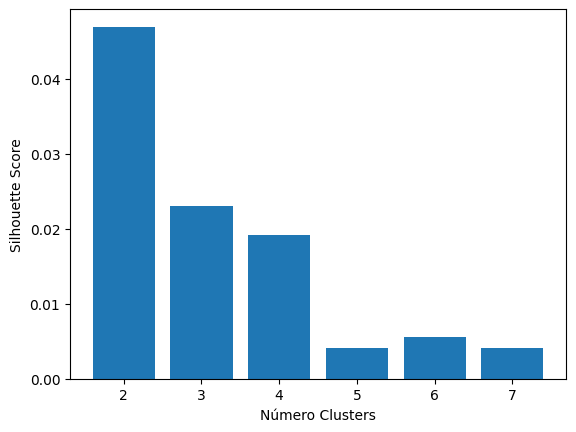

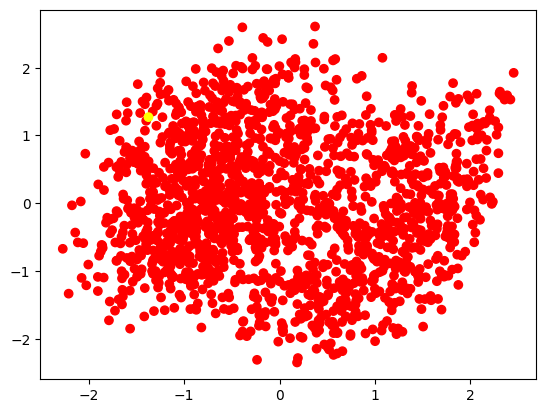

Random Index Score: 0.8246200186961188
Adjusted Random Index Score: 0.05318663058296535
Adjusted Mutual Info Score: 0.005638481287805309
Homogeneity: 0.008582648360233675
Completeness: 0.006054537976319249


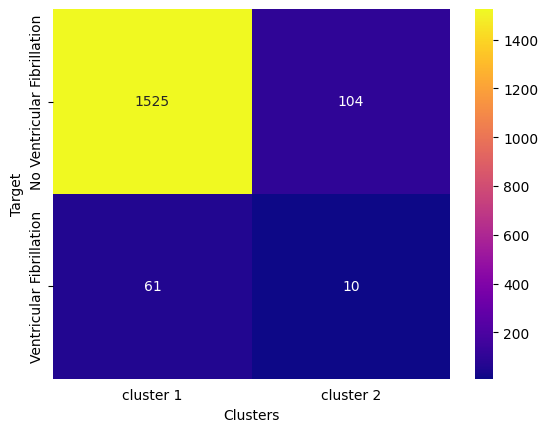

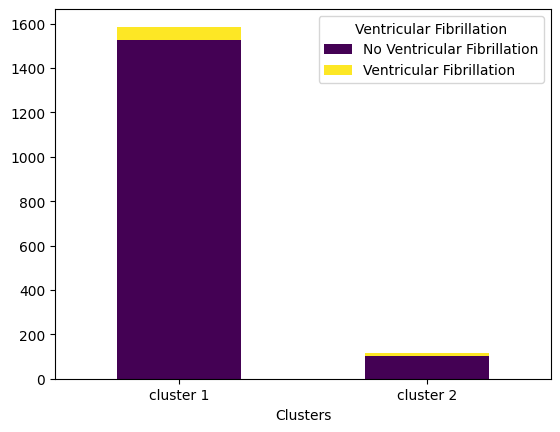

In [7]:
silhouette_score_list(X_cat_1H, affinity="hamming", linkage="complete")

pca_visualization2D(
    X_cat_1H, 2, affinity="hamming", linkage="complete")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="hamming", linkage="complete").fit(X_cat_1H), truncate_mode="level", p=7
                )

df = clustering_metrics(X_cat_1H, 2,
                   affinity="hamming", linkage="complete")





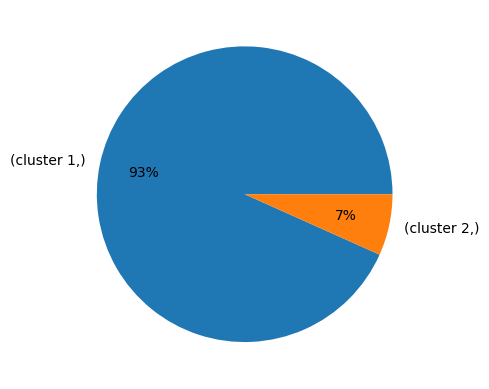

In [8]:
plot_percentage_cluster(df)


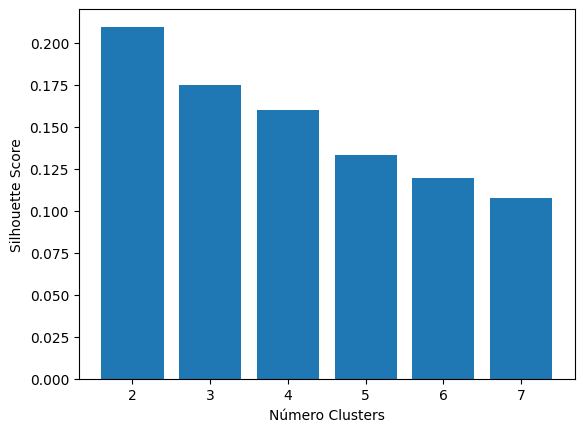

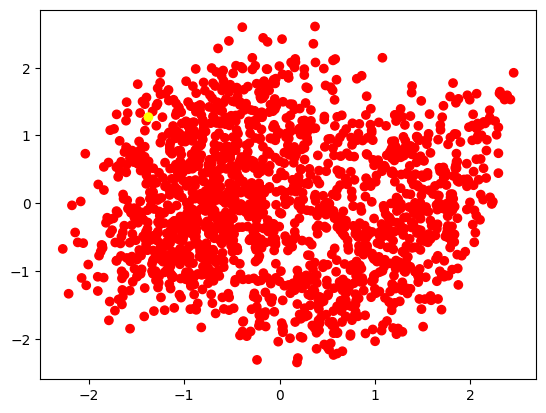

Random Index Score: 0.9209915867465291
Adjusted Random Index Score: 0.025501466585878627
Adjusted Mutual Info Score: 0.019855211016437672
Homogeneity: 0.010789137078837474
Completeness: 0.3771570665407378


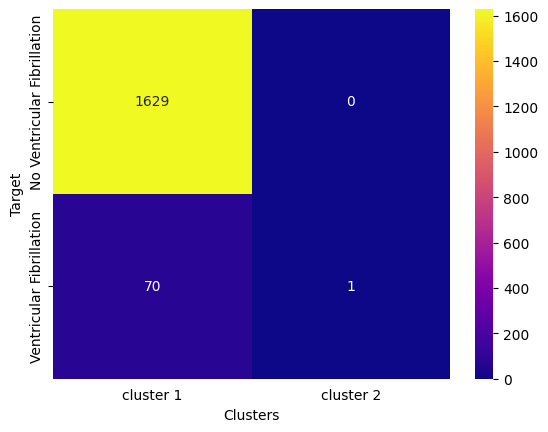

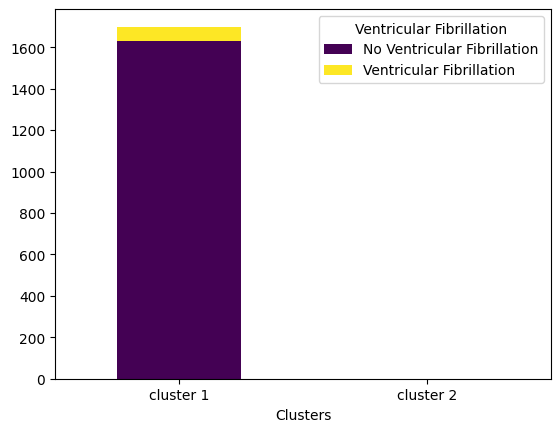

In [9]:
silhouette_score_list(X_cat_1H, affinity="hamming", linkage="single")

pca_visualization2D(
    X_cat_1H, 2, affinity="hamming", linkage="single")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="hamming", linkage="single").fit(X_cat_1H), truncate_mode="level", p=60
                )

df = clustering_metrics(X_cat_1H, 2,
                   affinity="hamming", linkage="single")


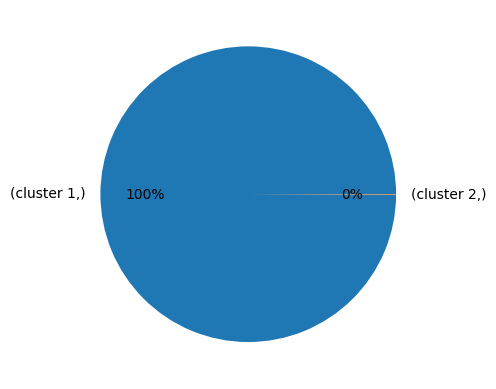

In [10]:
plot_percentage_cluster(df)


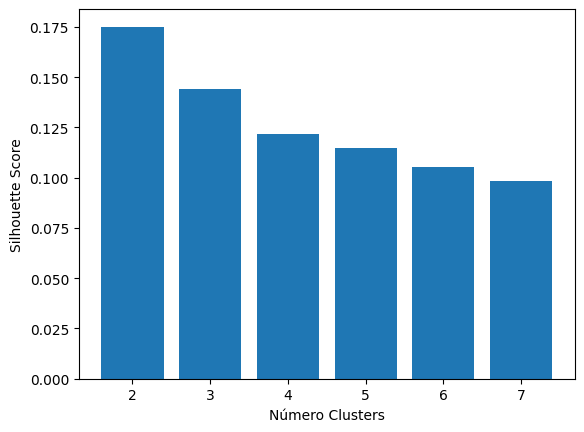

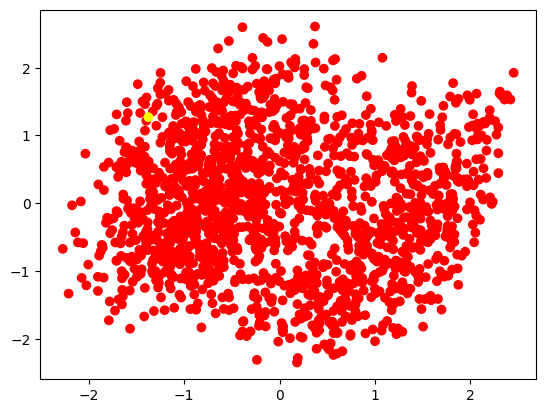

Random Index Score: 0.9209915867465291
Adjusted Random Index Score: 0.04864774035626705
Adjusted Mutual Info Score: 0.026665892502567113
Homogeneity: 0.015291736809436851
Completeness: 0.20487309882495322


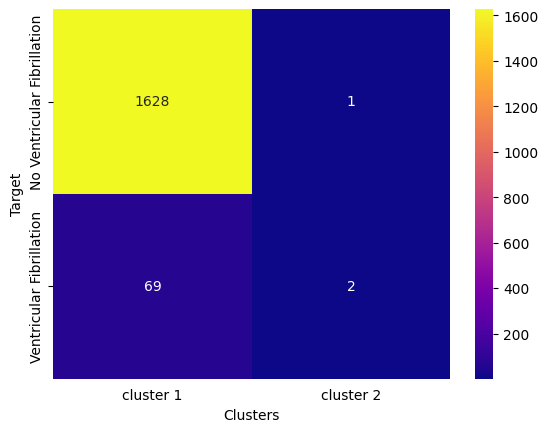

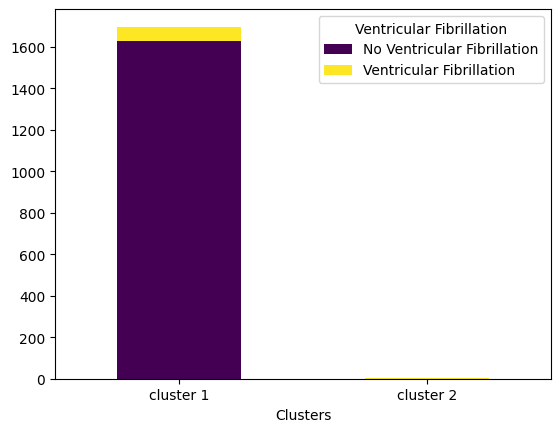

In [11]:
silhouette_score_list(X_cat_1H, affinity="hamming", linkage="average")

pca_visualization2D(
    X_cat_1H, 2, affinity="hamming", linkage="average")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="hamming", linkage="average").fit(X_cat_1H), truncate_mode="level", p=20
                )

df = clustering_metrics(X_cat_1H, 2,
                   affinity="hamming", linkage="average")


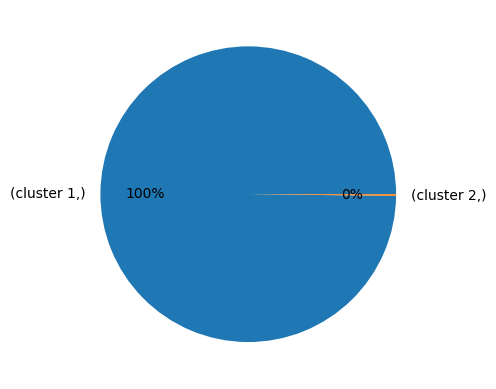

In [12]:
plot_percentage_cluster(df)


In [13]:
X_cat_gower = gower.gower_matrix(X_cat)

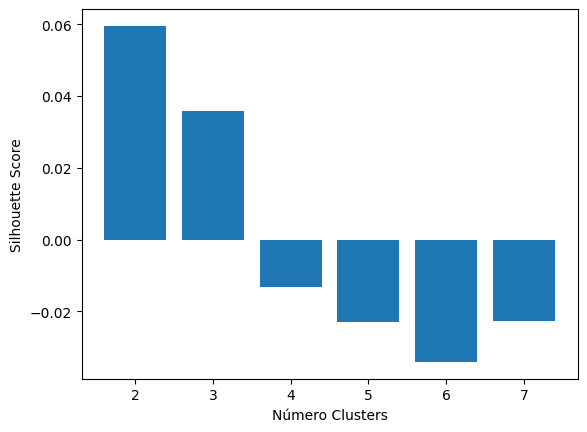

[0.27494802 0.21142853]
[[4.55534334e-02 5.77306448e-02 3.65587986e-01 1.28763560e-01
  5.41195555e-02 2.27439915e-01 3.40160006e-03 8.76247642e-01
  2.57392659e-02 2.07310548e-03 7.79566617e-04 7.09871120e-04
  5.10388330e-04 2.68832172e-03 1.29406643e-04 5.40048248e-05
  1.51634121e-04 1.85937807e-04 5.49562759e-04 2.16795419e-04
  4.69176861e-05 3.26084956e-05 4.14956617e-04 1.85884030e-02
  4.47584993e-03 1.32538024e-03 1.83794452e-04 1.80830402e-03
  1.48491478e-04 2.24577644e-04 1.04621844e-03 5.43915761e-03
  5.93293966e-04 6.04342394e-03 5.41317667e-05 5.35718564e-04
  2.20018140e-03 4.90407893e-02 2.45393887e-02 1.19511364e-02
  4.02683067e-03 2.19768429e-03 1.70546592e-02 6.91944079e-03
  9.59438610e-04 2.73450380e-04 1.06251464e-02 3.94244773e-04
  2.56729535e-03 7.24586897e-04 1.31561331e-03 2.48550574e-03
  3.82554399e-03 2.49392683e-03 1.39130945e-05 3.00351094e-04
  5.72325935e-05 2.88535156e-04 1.93725124e-03 6.59410363e-04
  4.17174131e-05 7.15813087e-04 2.34929996e-04

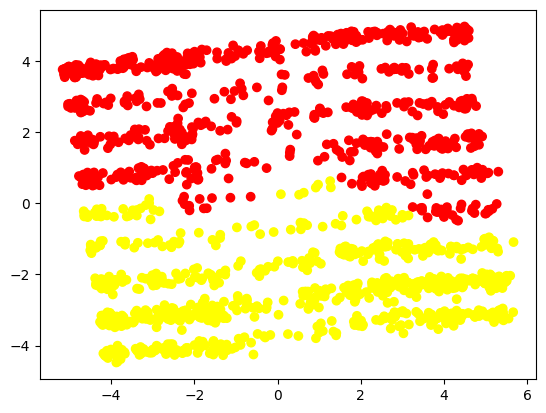

Random Index Score: 0.7254724232247343
Adjusted Random Index Score: 0.007869135339576967
Adjusted Mutual Info Score: -0.00081050969634253
Homogeneity: 0.0003988734539309124
Completeness: 0.00017462684392627412
NB com K Fold 

0.8523529411764705 & 0.9116841556543228 & 0.9210884353741496 & 0.9142033828001692

Accuracy: 0.8523529411764705
Error: 0.1476470588235294
Recall: 0.9210884353741496
Precision: 0.9116841556543228
FPR: 0.5869565217391306
Specifity: 0.4130434782608695
f1_score: 0.9142033828001692

NB com Repeated K Fold 

0.8549999999999999 & 0.9097345193034789 & 0.9240796036203328 & 0.9167155572512988

Accuracy: 0.8549999999999999
Error: 0.145
Recall: 0.9240796036203328
Precision: 0.9097345193034789
FPR: 0.5870167234759622
Specifity: 0.41298327652403777
f1_score: 0.9167155572512988

NB com Stratified K Fold 

0.8511764705882353 & 0.9156307644494424 & 0.9149659863945578 & 0.9128031900197152

Accuracy: 0.8511764705882353
Error: 0.14882352941176472
Recall: 0.9149659863945578
Precision:

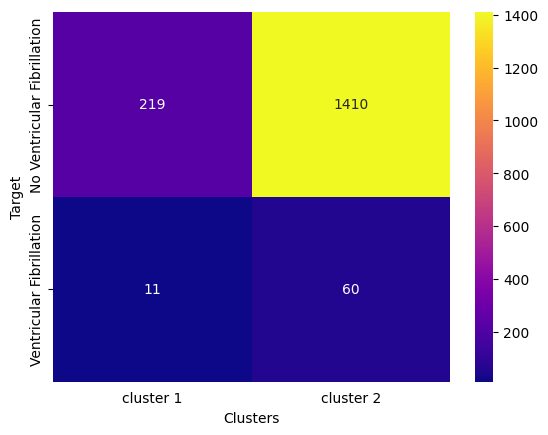

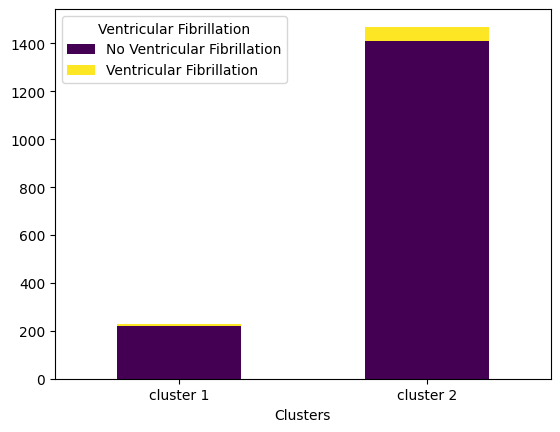

In [26]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2

silhouette_score_list(X_cat_gower, affinity="precomputed", linkage="complete")

pca_visualization2D(X_cat, 2, method=gower.gower_matrix, affinity="precomputed", linkage="complete")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="complete").fit(X_cat_gower), truncate_mode="level", p=7
                )

clusters = AgglomerativeClustering(
    n_clusters=2, affinity="precomputed", linkage="complete").fit_predict(X_cat_gower)

df = clustering_metrics(X_cat_gower, 2,
                   affinity="precomputed", linkage="complete")

bayes(BernoulliNB(), X_cat, clusters)



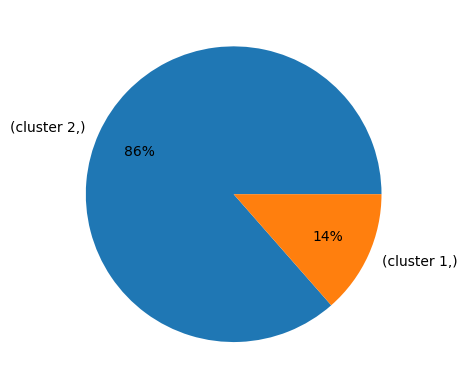

In [15]:
plot_percentage_cluster(df)


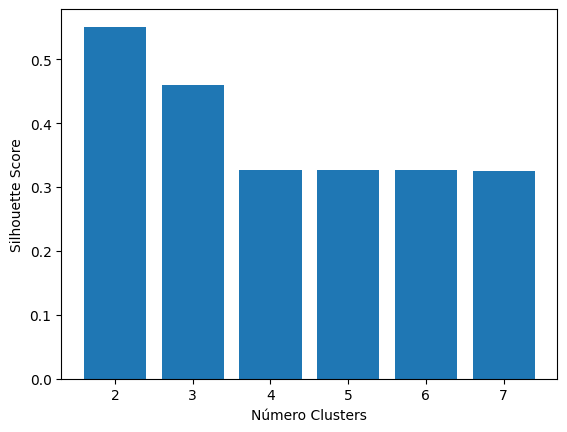

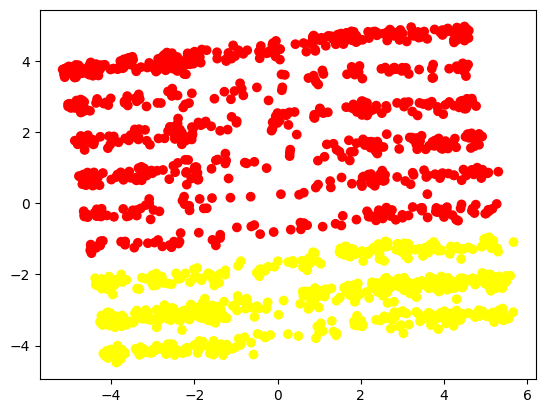

Random Index Score: 0.9209915867465291
Adjusted Random Index Score: 0.025501466585878627
Adjusted Mutual Info Score: 0.019855211016437672
Homogeneity: 0.010789137078837474
Completeness: 0.3771570665407378


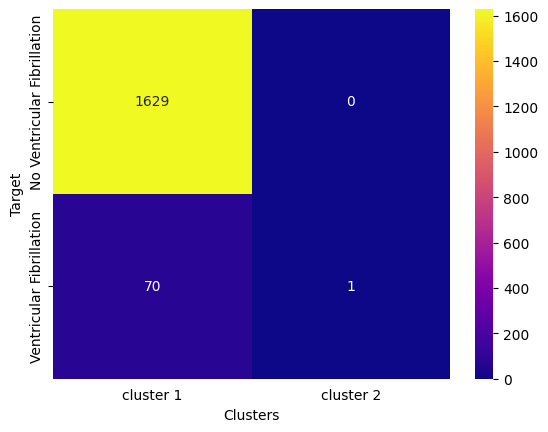

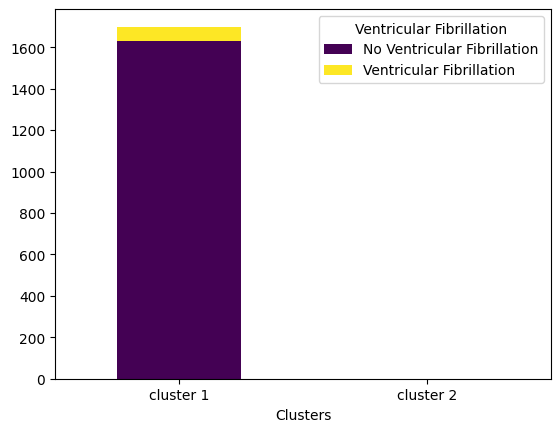

In [16]:
silhouette_score_list(X_cat_gower, affinity="precomputed", linkage="single")

pca_visualization2D(X_cat, 2, method=gower.gower_matrix,
                    affinity="precomputed", linkage="single")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="single").fit(X_cat_gower), truncate_mode="level", p=60
                )
                

df = clustering_metrics(X_cat_gower, 2,
                   affinity="precomputed", linkage="single")


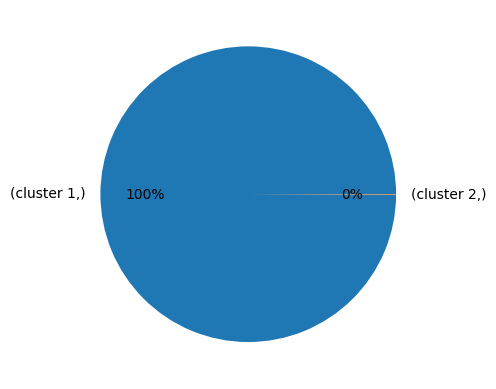

In [17]:
plot_percentage_cluster(df)


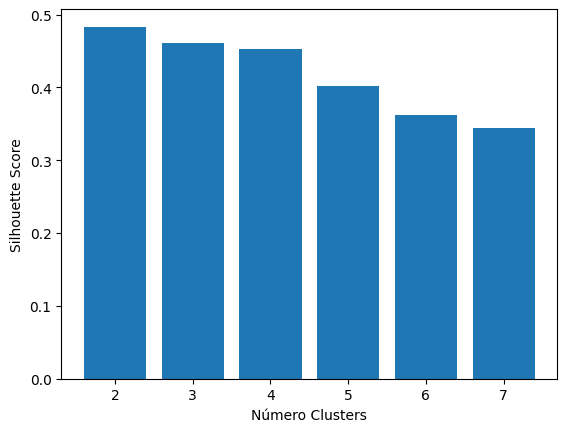

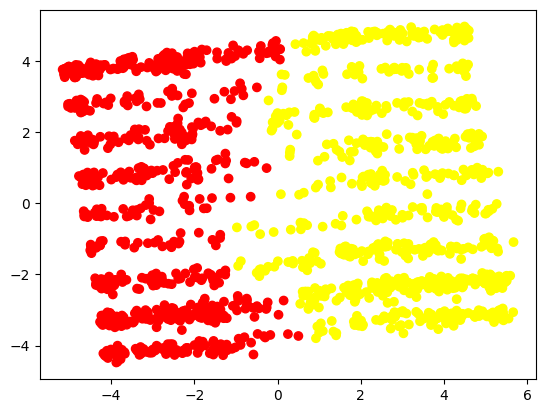

Random Index Score: 0.9188339161444449
Adjusted Random Index Score: 0.022666902134971065
Adjusted Mutual Info Score: 0.0067326184482730785
Homogeneity: 0.0046009238830360686
Completeness: 0.06164149600022114


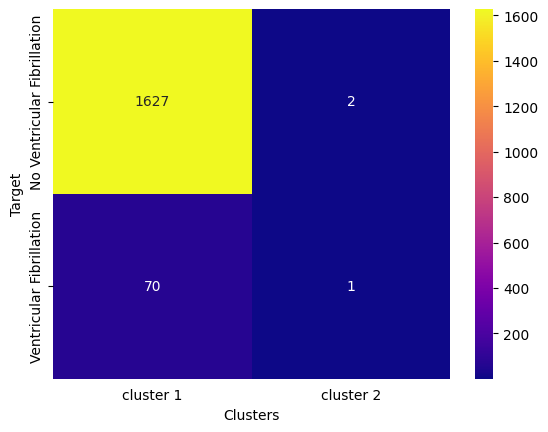

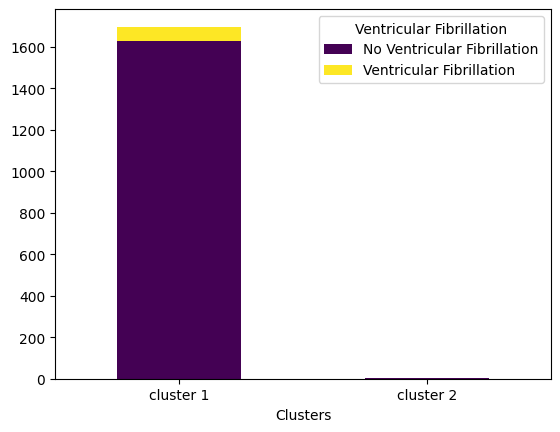

In [18]:
silhouette_score_list(X_cat_gower, affinity="precomputed", linkage="average")

pca_visualization2D(X_cat, 2, method=gower.gower_matrix,
                    affinity="precomputed", linkage="average")

plot_dendrogram(AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="average").fit(X_cat_gower),  truncate_mode="level", p=20
                )

df = clustering_metrics(X_cat_gower, 2,
                   affinity="precomputed", linkage="average")


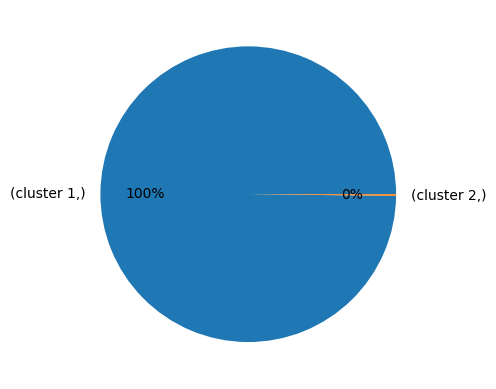

In [19]:
plot_percentage_cluster(df)
